# Scalable GP Classification (w/ KISS-GP)

This example shows how to use a `GridInterpolationVariationalStrategy` module. This classification module is designed for when the function you're modeling has 2-3 dimensional inputs and you don't believe that the output can be additively decomposed.

In this example, the function is checkerboard of 1/3x1/3 squares with labels of -1 or 1


 Here we use KISS-GP (https://arxiv.org/pdf/1503.01057.pdf) to classify

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from math import exp

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/gpleiss/anaconda3/envs/gpytorch/lib/python3.7/site-packages/matplotlib/__init__.py:999: UserWarning: Duplicate key in file "/home/gpleiss/.dotfiles/matplotlib/matplotlibrc", line #57
  (fname, cnt))


In [2]:
# We make an nxn grid of training points
# In [0,1]x[0,1] spaced every 1/(n-1)
n = 30
train_x = torch.zeros(int(pow(n, 2)), 2)
train_y = torch.zeros(int(pow(n, 2)))
for i in range(n):
    for j in range(n):
        train_x[i * n + j][0] = float(i) / (n - 1)
        train_x[i * n + j][1] = float(j) / (n - 1)
        # True function is checkerboard of 1/3x1/3 squares with labels of -1 or 1
        train_y[i * n + j] = pow(-1, int(3 * i / n + int(3 * j / n)))

In [3]:
from gpytorch.models import AbstractVariationalGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import GridInterpolationVariationalStrategy

class GPClassificationModel(AbstractVariationalGP):
    def __init__(self, grid_size=10, grid_bounds=[(0, 1), (0, 1)]):
        variational_distribution = CholeskyVariationalDistribution(int(pow(grid_size, len(grid_bounds))))
        variational_strategy = GridInterpolationVariationalStrategy(self, grid_size, grid_bounds, variational_distribution)
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(
                    exp(0), exp(3), sigma=0.1, transform=torch.exp
                )
            )
        )
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


model = GPClassificationModel()
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

In [4]:
from gpytorch.mlls.variational_elbo import VariationalELBO

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# n_data refers to the amount of training data
mll = VariationalELBO(likelihood, model, train_y.numel())

def train():
    num_iter = 150
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, num_iter, loss.item()))
        optimizer.step()
        
# Get clock time
%time train()

Iter 1/150 - Loss: 1.093
Iter 2/150 - Loss: 10.264
Iter 3/150 - Loss: 2.470
Iter 4/150 - Loss: 2.888
Iter 5/150 - Loss: 5.368
Iter 6/150 - Loss: 4.434
Iter 7/150 - Loss: 2.389
Iter 8/150 - Loss: 1.478
Iter 9/150 - Loss: 1.714
Iter 10/150 - Loss: 2.231
Iter 11/150 - Loss: 2.096
Iter 12/150 - Loss: 1.543
Iter 13/150 - Loss: 1.146
Iter 14/150 - Loss: 0.978
Iter 15/150 - Loss: 0.917
Iter 16/150 - Loss: 0.929
Iter 17/150 - Loss: 0.922
Iter 18/150 - Loss: 0.837
Iter 19/150 - Loss: 0.866
Iter 20/150 - Loss: 0.829
Iter 21/150 - Loss: 0.843
Iter 22/150 - Loss: 0.717
Iter 23/150 - Loss: 0.729
Iter 24/150 - Loss: 0.772
Iter 25/150 - Loss: 0.867
Iter 26/150 - Loss: 0.771
Iter 27/150 - Loss: 0.667
Iter 28/150 - Loss: 0.670
Iter 29/150 - Loss: 0.656
Iter 30/150 - Loss: 0.627
Iter 31/150 - Loss: 0.600
Iter 32/150 - Loss: 0.556
Iter 33/150 - Loss: 0.589
Iter 34/150 - Loss: 0.569
Iter 35/150 - Loss: 0.564
Iter 36/150 - Loss: 0.556
Iter 37/150 - Loss: 0.496
Iter 38/150 - Loss: 0.496
Iter 39/150 - Loss: 

(-0.5, 1.5)

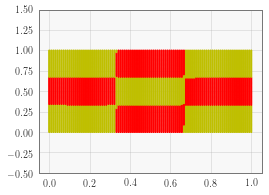

In [5]:
# Set model and likelihood into eval mode
model.eval()
likelihood.eval()

# Initialize figiure an axis
f, ax = plt.subplots(1, 1, figsize=(4, 3))

n = 100
test_x = torch.zeros(int(pow(n, 2)), 2)
for i in range(n):
    for j in range(n):
        test_x[i * n + j][0] = float(i) / (n-1)
        test_x[i * n + j][1] = float(j) / (n-1)
        
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(test_x))

# prob<0.5 --> label -1 // prob>0.5 --> label 1
pred_labels = predictions.mean.ge(0.5).float().mul(2).sub(1).numpy()
# Colors = yellow for 1, red for -1
color = []
for i in range(len(pred_labels)):
    if pred_labels[i] == 1:
        color.append('y')
    else:
        color.append('r')
        
# Plot data a scatter plot
ax.scatter(test_x[:, 0], test_x[:, 1], color=color, s=1)
ax.set_ylim([-0.5, 1.5])